------
**NLP1 Assignment 1: Elynn Weijland (13895958) and Linda Hovius (12205184)**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [1]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [2]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2021-11-17 19:34:04--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.05s   

2021-11-17 19:34:04 (12.0 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2021-11-17 19:34:05--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [3]:
with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))
for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

In [4]:
def content_to_text(content):
  text = ''
  for sent in content:
    for combi in sent:
      word = combi[0]
      text = text+' '+word
  return text
def content_to_POStext(content):
  text = ''
  for sent in content:
    for combi in sent:
      word = combi[0]+'_'+combi[1]
      text = text+' '+word
  return text

reviewsDF = pd.DataFrame(reviews)
reviewsDF['text'] = reviewsDF['content'].apply(content_to_text)
reviewsDF['nr_tokens'] = [len(txt.split()) for txt in reviewsDF['text']]
reviewsDF['word_POS'] = reviewsDF['content'].apply(content_to_POStext)  
reviewsDF.head(2)

,cv,sentiment,content,text,nr_tokens,word_POS
0,0,NEG,"[[[Two, CD], [teen, JJ], [couples, NNS], [go, ...","Two teen couples go to a church party , drink...",770,Two_CD teen_JJ couples_NNS go_VBP to_TO a_DT ...
1,1,NEG,"[[[Damn, JJ], [that, IN], [Y2K, CD], [bug, NN]...",Damn that Y2K bug . It 's got a head start in...,282,Damn_JJ that_IN Y2K_CD bug_NN ._. It_PRP 's_V...


# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip().split())
    line_cnt += 1
    if line_cnt > 4:
      break

['type=weaksubj', 'len=1', 'word1=abandoned', 'pos1=adj', 'stemmed1=n', 'priorpolarity=negative']
['type=weaksubj', 'len=1', 'word1=abandonment', 'pos1=noun', 'stemmed1=n', 'priorpolarity=negative']
['type=weaksubj', 'len=1', 'word1=abandon', 'pos1=verb', 'stemmed1=y', 'priorpolarity=negative']
['type=strongsubj', 'len=1', 'word1=abase', 'pos1=verb', 'stemmed1=y', 'priorpolarity=negative']
['type=strongsubj', 'len=1', 'word1=abasement', 'pos1=anypos', 'stemmed1=y', 'priorpolarity=negative']



Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [6]:
sent_lex = dict()
weight_lex =dict()
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    lijst = line.strip().split()
    sent_lex[lijst[2][6:]]=lijst[5][14:]
    if lijst[0][5:10].startswith('str'):
      weight_lex[lijst[2][6:]]=3
    elif lijst[0][5:10].startswith('wea'):
      weight_lex[lijst[2][6:]]=1

In [7]:
def create_unweighted_polarity(threshold,text):
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1
      elif sent_lex[t]=='negative':
        polarity-=1
  return polarity

In [8]:
thresh = 0
reviewsDF['unweighted_polarity'] = [create_unweighted_polarity(thresh,txt) for txt in reviewsDF['text']]
print(f"bias towards positive words in ALL reviews with threshold {thresh} is: {reviewsDF['unweighted_polarity'].mean()}")
thresh = -8
reviewsDF['unweighted_polarity'] = [create_unweighted_polarity(thresh,txt) for txt in reviewsDF['text']]
print(f"bias towards positive words in ALL reviews with threshold {thresh} is: {reviewsDF['unweighted_polarity'].mean()}")

bias towards positive words in ALL reviews with threshold 0 is: 7.194
bias towards positive words in ALL reviews with threshold -8 is: -0.806


In [12]:
reviewsDF['unweighted_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['unweighted_polarity']]
print(f"Accuracy of unweighted sign-only classification (with fixed threshold): {(len(reviewsDF[reviewsDF.sentiment==reviewsDF.unweighted_predict])/len(reviewsDF))}")

Accuracy of unweighted sign-only classification (with fixed threshold): 0.679


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [9]:
def create_weighted_polarity(threshold,text):
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1*weight_lex[t]
      elif sent_lex[t]=='negative':
        polarity-=1*weight_lex[t]
  return polarity

In [10]:
thresh = 0
reviewsDF['weighted_polarity'] = [create_weighted_polarity(thresh,txt) for txt in reviewsDF['text']]
print(f"bias towards positive words in ALL reviews with threshold {thresh} is: {reviewsDF['weighted_polarity'].mean()}")
thresh = -21
reviewsDF['weighted_polarity'] = [create_weighted_polarity(thresh,txt) for txt in reviewsDF['text']]
print(f"bias towards positive words in ALL reviews with threshold {thresh} is: {reviewsDF['weighted_polarity'].mean()}")

bias towards positive words in ALL reviews with threshold 0 is: 14.445
bias towards positive words in ALL reviews with threshold -21 is: -6.555


In [14]:
reviewsDF['weighted_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['weighted_polarity']]
print(f"Accuracy of weighted classification (with fixed threshold): {(len(reviewsDF[reviewsDF.sentiment==reviewsDF.weighted_predict])/len(reviewsDF))}")

Accuracy of weighted classification (with fixed threshold): 0.6935


#### (Q.1.4) Make a barplot of the two results (0.5pt)

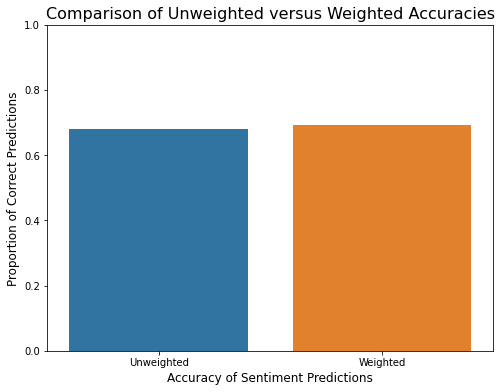

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
y = [len(reviewsDF[reviewsDF.sentiment==reviewsDF.unweighted_predict])/len(reviewsDF), 
     len(reviewsDF[reviewsDF.sentiment==reviewsDF.weighted_predict])/len(reviewsDF)]
x = 'Unweighted Weighted'.split()
sns.barplot(x=x,y=y,ax=ax)
ax.set_xlabel("Accuracy of Sentiment Predictions",fontsize=12)
ax.set_ylabel("Proportion of Correct Predictions",fontsize=12)
ax.set_title("Comparison of Unweighted versus Weighted Accuracies", fontsize=16)
ax.set_ylim(0,1)
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

We have seen that people tend to use more positive words than negative ones, irrespective of their sentiment. That means that longer texts will have more 'extra' positive words than shorter texts. Eg: if 100-word reviews have, on average, 8 more positive than negative words, then 1000-word reviews will on average have 80 more positive than negative words. 



In [16]:
thresh = 0
reviewsDF['weighted_polarity'] = [create_weighted_polarity(thresh,txt) for txt in reviewsDF['text']]
meanthres = reviewsDF['weighted_polarity'].mean() / reviewsDF['nr_tokens'].mean()

def create_varthres_weighted_polarity(text, nr_tokens,meanthres=meanthres):
  polarity = -(nr_tokens*meanthres)
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1*weight_lex[t]
      elif sent_lex[t]=='negative':
        polarity-=1*weight_lex[t]
  return polarity

reviewsDF['varthres_polarity'] = reviewsDF.apply(lambda row: create_varthres_weighted_polarity(row.text,row.nr_tokens), axis=1)
reviewsDF['varthres_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['varthres_polarity']]
print(f"Accuracy of weighted classification (with variable threshold): {(len(reviewsDF[reviewsDF.sentiment==reviewsDF.varthres_predict])/len(reviewsDF))}")

Accuracy of weighted classification (with variable threshold): 0.6945


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

Naive Bayes relies on the comparison of word distributions over different classes. If a word does not occur in one class, it has no distribution in that class and can therefore not be compared against the distribution in the other class. 

If you would still include the word, then this would lead to either:
- you only add the log probability of that word to the total probability of the class where it occurs, but skip it for the class where it does not occur. Since these log probabilities are all negative, it would actually DECREASE the chance of the review belonging to that class
- or you include a probability of 0 to the missing class, which leads to a total chance of 0 of that review belonging to that class (since we multiply probabilities).

Both are not what we want, therefore we skip it. Which, by the way, is also not what we want, since realistically, nearly every word will occur sooner or later in every class, so it should have some distribution.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [17]:
train = reviewsDF[reviewsDF['cv']<=899][['cv', 'sentiment', 'text', 'nr_tokens']]
test = reviewsDF[(reviewsDF['cv']>=900)&(reviewsDF['cv']<=999)][['cv', 'sentiment', 'text', 'nr_tokens']]
print(f"length training set: {len(train)}, with {len(train[train['sentiment']=='POS'])} Positive reviews")
print(f"length test set: {len(test)}, with {len(test[test['sentiment']=='POS'])} Positive reviews")

length training set: 1800, with 900 Positive reviews
length test set: 200, with 100 Positive reviews


In [18]:
"""
We start with creating two frequency dictionaries, one for words in the positive reviews, one for the negative ones.
Of course, we only use the reviews in the training set, test set remains untouched. If a word is *not* in the 
training set, it is not in either dictionary. The text remains in its original form, except for making everything lowercase.
Next, we create two probability dictionaries, that have these counts normalized and transformed to log likelihoods
As a last step, the two priors are calculated.
"""

# step 1: create two dictionaries that only contain words from their own class:
postexts = ''.join(train[train['sentiment']=='POS']['text'].str.lower()).split()
lookup_POS = {t for t in postexts} # create a set to only have unique entries
lookup_POS = {t:0 for t in lookup_POS} # change the set into a dictionary
negtexts = ''.join(train[train['sentiment']=='NEG']['text'].str.lower()).split()
lookup_NEG = {t for t in negtexts} 
lookup_NEG = {t:0 for t in lookup_NEG}

# step 2: count the number of times these words occur in their own class only:
for t in postexts:
  lookup_POS[t] += 1
for t in negtexts:
  lookup_NEG[t] += 1

# step 3: transform the counts into two new dictionaries with the normalized log-likelihoods per class:
lookup_POSprob = dict(); lookup_NEGprob = dict()
for word in lookup_POS:
    lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)) ) 
for word in lookup_NEG:
    lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)) ) 

# step 4: create the two priors (both a probability)
logprior_POS = np.log( len(train[train['sentiment']=='POS']) / len(train) )
logprior_NEG = np.log( len(train[train['sentiment']=='NEG']) / len(train) )

In [19]:
def calculate_class_prob_unsmoothed(text, lookup_POSprob=lookup_POSprob, lookup_NEGprob=lookup_NEGprob, 
                         logprior_POS=logprior_POS, logprior_NEG=logprior_NEG):
  """
  A function to classify reviews into either a positive or a negative sentiment, based on premade
  log probabilities per word and precalculated priors. It uses an unsmoothed version of
  the Naive Bayes algorithm.

  This function takes as input: 
  - raw text in string format
  - two lookup dictionaries (one for each class) with normalized (natural) log probabilites for each word
  - priors for both both classes (float format)

  The function calculates the total likelihood of a text belonging to one of these two classes,
  based on unsmoothed Naive Bayes. It returns a POS or NEG class prediction.
  """

  prob_pos = logprior_POS; prob_neg = logprior_NEG
  for token in text.split():
    t=token.lower()
    if t in lookup_POSprob and t in lookup_NEGprob: # only use tokens that occur in both classes (otherwise, skip this word)
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
    else:
      continue
      
  if prob_pos > prob_neg:
    return 'POS'
  else:
    return 'NEG'

In [21]:
# Predict the sentiment of the reviews in the testset
test_predict = test['text'].apply(calculate_class_prob_unsmoothed)
test_results=[]
for true, predict in zip(test.sentiment,test_predict):
  if true==predict:
    test_results.append(1)
  else:
    test_results.append(0)
accuracy=sum(test_results)/len(test_results)
print(f"Accuracy of unsmoothed Naive Bayes classification on test data: {accuracy}")

Accuracy of unsmoothed Naive Bayes classification on test data: 0.83


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*Write your answer here.*
The accuracy we obtained above is lower than 0.9. This means that if a classifier learns to predict every review as "positive", it will already have an accuracy of 90% and outperform our baseline. 
This means that a "stupid" algorithm can obtain a high accuracy; there is no need for the algorithm to learn. But the essence of Machine Learning is learning!
This is the reason why we need other performance metrics for disbalanced classes. We better rely on metrics like the F1 score, or choose either precision or recall, depending on what kind of loss we want to minimize.

In [22]:
train2 = train[ ((train.sentiment=='NEG') & (train['cv']<=89)) | (train.sentiment=='POS') ].copy()
print(f"length of train2: {len(train2)}, with {len(train2[train2.sentiment=='POS'])} positive and {len(train2[train2.sentiment=='NEG'])} negative reviews")
test2 = test[ ((test.sentiment=='NEG') & (test.cv<=909)) | (test.sentiment=='POS') ].copy()
print(f"length of test2: {len(test2)}, with {len(test2[test2.sentiment=='POS'])} positive and {len(test2[test2.sentiment=='NEG'])} negative reviews")

length of train2: 990, with 900 positive and 90 negative reviews
length of test2: 110, with 100 positive and 10 negative reviews


In [23]:
# step 1: create two dictionaries that only contain words from their own class:
postexts = ''.join(train2[train2['sentiment']=='POS']['text'].str.lower()).split()
lookup_POS = {t for t in postexts} # create a set to only have unique entries
lookup_POS = {t:0 for t in lookup_POS} # change the set into a dictionary
negtexts = ''.join(train2[train2['sentiment']=='NEG']['text'].str.lower()).split()
lookup_NEG = {t for t in negtexts}
lookup_NEG = {t:0 for t in lookup_NEG} 

# step 2: fill the dictionaries with frequency counts of their own class' occurrence
for t in postexts:
  lookup_POS[t] += 1
for t in negtexts:
  lookup_NEG[t] += 1

# step 3: transform the counts into two new dictionaries with the normalized log-likelihoods per class:
lookup_POSprob = dict(); lookup_NEGprob = dict()
for word in lookup_POS:
    lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)) ) 
for word in lookup_NEG:
    lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)) ) 

# step 4: create the two priors (both a probability)
logprior_POS = np.log( len(train2[train2['sentiment']=='POS']) / len(train2) )
logprior_NEG = np.log( len(train2[train2['sentiment']=='NEG']) / len(train2) ) 

In [ ]:
test2['predict_NB'] = test2['text'].apply(calculate_class_prob_unsmoothed)
print(f"Accuracy of unsmoothed Naive Bayes classification on disbalanced test data: {len(test2[test2.sentiment==test2.predict_unsmoothed_NB])/len(test2):.3f}")

# As it turns out, our NB classifier is not stupid, it has learned something. But using that learning on a disbalanced dataset does not do its
# accuracy much good; its performance went down by 0.17.
# Looking at what the algorithm does exactly, shows why it did not go for the easy "everything positive" prediction:
# -1) when we transform the count dictionaries into probability dictionaries, we normalize by dividing by text length. 
# Since the length of all negative texts is much smaller than the length of all positive texts, the actual probabilities are not very different between the two classes, 
# if the underlying word counts are also not too different. 
# 2) Having so few negative examples means that the negative vocabulary also remains small. And this being an unsmoothed NB means that only this limited amount of
# words is used for the comparison. A lot of these words will be words that are so common that they don't help to discern (like stop words). There is too little signal
# left in the noise.

Accuracy of unsmoothed Naive Bayes classification on disbalanced test data: 0.773


'\ndit klopt! Je hebt nl maar een hele kleine negative vocab en gebruikt alleen de woorden die in beide voorkomen, dus het grootste deel van wat je gebruikt is noise\nEr zijn misschien een paar signaalwoorden voor negatieve teksten die toevallig ook een mention hebben in een positive tekst, maar dit is heel weinig signaal\nSimone: het grote probleem waarom je classifier slecht performt is dat je hier nog geen smoothing doet. Bij smoothing krijg je hele andere uitkomsten.\n\n'

## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [24]:
train = reviewsDF[reviewsDF['cv']<=899][['cv', 'sentiment', 'text', 'nr_tokens']]
test = reviewsDF[(reviewsDF['cv']>=900)&(reviewsDF['cv']<=999)][['cv', 'sentiment', 'text', 'nr_tokens']]

"""
We start with creating a full vocab of all tokens in the training set, with frequency set at 1,
in order to enable comparisons over classes, giving them the same vocab size
Next, we create two frequency dictionaries, one for words in the positive reviews, one for the negative ones.
Finally, we create two probability dictionaries, that have these counts normalized and transformed to log likelihoods
plus the two priors
"""
# step 1: instantiate two count dictionaries with all word counts set to 1
vocab = {t for t in ' '.join(train['text'].str.lower()).split()}
lookup_POS = {t:1 for t in vocab}; lookup_NEG = {t:1 for t in vocab}
lookup_POS["UNK"]=1; lookup_NEG["UNK"]=1 # We add a key "UNK" to this dictionary with value 1

# step 2: fill the two dictionaries with the word counts from the texts in their class:
postexts = ''.join(train[train['sentiment']=='POS']['text'].str.lower()).split()
for t in postexts:
  lookup_POS[t] += 1
negtexts = ''.join(train[train['sentiment']=='NEG']['text'].str.lower()).split()
for t in negtexts:
  lookup_NEG[t] += 1

# step 3: create two new dictionaries with the normalized log-likelihoods of these counts per class:
lookup_POSprob = dict(); lookup_NEGprob = dict()
for word in lookup_POS:
  lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)+len(vocab)) )
for word in lookup_NEG:
  lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(vocab)) )  

# step 4: create the two priors (both a probability)
logprior_POS = np.log( len(train[train['sentiment']=='POS']) / len(train) )
logprior_NEG = np.log( len(train[train['sentiment']=='NEG']) / len(train) ) 

In [33]:
def calculate_class_prob_smoothed(text, lookup_POSprob=lookup_POSprob, lookup_NEGprob=lookup_NEGprob, 
                         logprior_POS=logprior_POS, logprior_NEG=logprior_NEG):
  """
  A function to classify reviews into either a positive or a negative sentiment, based on premade
  log probabilities per word and precalculated priors. It uses an unsmoothed version of
  the Naive Bayes algorithm.

  This function takes as input: 
  - raw text in string format
  - two lookup dictionaries (one for each class) with normalized (natural) log probabilites for each word
  - log priors for both both classes (float format)

  The function calculates the total likelihood of a text belonging to one of these two classes,
  based on Naive Bayes with LaPlace smoothing. It returns a POS or NEG class prediction.
  """

  prob_pos = logprior_POS; prob_neg = logprior_NEG
  for token in text.split():
    t=token.lower()
    if t in lookup_POSprob: # if it is in one dictionary, it is also in the other
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
    else:
      continue
      
  if prob_pos > prob_neg:
    return 'POS'
  else:
    return 'NEG'

In [34]:
test_predict = test['text'].apply(calculate_class_prob_smoothed)
test_results=[]
for true, predict in zip(test.sentiment,test_predict):
  if true==predict:
    test_results.append(1)
  else:
    test_results.append(0)
print(f"Accuracy of Naive Bayes classification with LaPlace smoothing on test data: {sum(test_results)/len(test_results)}")

Accuracy of Naive Bayes classification with LaPlace smoothing on test data: 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [35]:
accuracy_results = []
NBdata = reviewsDF[['sentiment', 'text']]

# Calculate log probabilities based on the training data
for i in range(10):
  val = NBdata[i::10]
  train = NBdata[~NBdata.isin(val)].dropna()

  alltext = {t for t in ' '.join(train['text'].str.lower()).split()}
  lookup_POS = {t:1 for t in alltext}; lookup_NEG = {t:1 for t in alltext}
  postexts = ''.join(train[train['sentiment']=='POS']['text'].str.lower()).split()
  for t in postexts:
    lookup_POS[t] += 1
  negtexts = ''.join(train[train['sentiment']=='NEG']['text'].str.lower()).split()
  for t in negtexts:
    lookup_NEG[t] += 1
  lookup_POSprobtrain = dict();   lookup_NEGprobtrain = dict()
  for word in lookup_POS:
    lookup_POSprobtrain[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
  for word in lookup_NEG:
    lookup_NEGprobtrain[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  
  logprior_POStrain = np.log( len(train[train['sentiment']=='POS']) / len(train) )
  logprior_NEGtrain = np.log( len(train[train['sentiment']=='NEG']) / len(train) )

  # Calculate score for the held-out test set
  val_predict = val['text'].apply(calculate_class_prob_smoothed, lookup_POSprob=lookup_POSprobtrain, lookup_NEGprob=lookup_NEGprobtrain, logprior_POS=logprior_POStrain, logprior_NEG=logprior_NEGtrain)
  test_results=[]
  for true, predict in zip(val.sentiment,val_predict):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of Naive Bayes classification (fold {i}): {sum(test_results)/len(test_results)}, with {sum(test_results)} correct")
  accuracy_results.append(sum(test_results)/len(test_results))

Accuracy of Naive Bayes classification (fold 0): 0.79, with 158 correct
Accuracy of Naive Bayes classification (fold 1): 0.835, with 167 correct
Accuracy of Naive Bayes classification (fold 2): 0.805, with 161 correct
Accuracy of Naive Bayes classification (fold 3): 0.825, with 165 correct
Accuracy of Naive Bayes classification (fold 4): 0.78, with 156 correct
Accuracy of Naive Bayes classification (fold 5): 0.845, with 169 correct
Accuracy of Naive Bayes classification (fold 6): 0.83, with 166 correct
Accuracy of Naive Bayes classification (fold 7): 0.775, with 155 correct
Accuracy of Naive Bayes classification (fold 8): 0.83, with 166 correct
Accuracy of Naive Bayes classification (fold 9): 0.84, with 168 correct


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [37]:
print(f"mean of 10-fold NB with smoothing: {np.mean(accuracy_results):.3f}, variance: {np.var(accuracy_results):.4f}")
print(f"number of tokens in the last held-out training set: {len(alltext)}")

mean of 10-fold NB with smoothing: 0.815, variance: 0.0006
number of tokens in the last held-out training set: 45643


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [38]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [39]:
def calculate_class_prob_Porter(text, lookup_POSprob, lookup_NEGprob, 
                         logprior_POS, logprior_NEG):
  
  """
  A function to classify reviews into either a positive or a negative sentiment, based on premade
  log probabilities per word and precalculated priors. It uses a smoothed version of
  the Naive Bayes algorithm. As preprocessing, all tokens are lowercased and reduced to their Porter stem.

  This function takes as input: 
  - text in string format
  - two lookup dictionaries (one for each class) with normalized (natural) log probabilites for each word
  - log priors for both both classes (float format)

  The function calculates the total likelihood of a text belonging to one of these two classes. 
  It returns a POS or NEG class prediction.
  """

  prob_pos = logprior_POS; prob_neg = logprior_NEG
  tokenlist = [stemmer.stem(t.lower()) for t in text.split()]
  for t in tokenlist:
    if t in lookup_POSprob:
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
  if prob_pos > prob_neg:
    return 'POS'
  else:
    return 'NEG'

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [40]:
accuracy_results = []
NBdata = reviewsDF[['sentiment', 'text']]

for i in range(10):
  val = NBdata[i::10].copy()
  train = NBdata[~NBdata.isin(val)].dropna()

  # Calculate log probabilities based on the training data
  postexts = ''.join(train[train['sentiment']=='POS']['text'].str.lower()).split()
  postexts = [stemmer.stem(t) for t in postexts]
  negtexts = ''.join(train[train['sentiment']=='NEG']['text'].str.lower()).split()
  negtexts = [stemmer.stem(t) for t in negtexts]
  vocab = {t for t in postexts}
  vocab.update({t for t in negtexts})
  lookup_POS = {t:1 for t in vocab}; lookup_NEG = {t:1 for t in vocab}
  for t in postexts:
    lookup_POS[t] += 1
  for t in negtexts:
    lookup_NEG[t] += 1
  lookup_POSprobtrain = dict(); lookup_NEGprobtrain = dict()
  for word in lookup_POS:
    lookup_POSprobtrain[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
  for word in lookup_NEG:
    lookup_NEGprobtrain[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  
  logprior_POStrain = np.log( len(train[train['sentiment']=='POS']) / len(train) )
  logprior_NEGtrain = np.log( len(train[train['sentiment']=='NEG']) / len(train) )

  # Calculate score for the held-out test set
  val_predict = val['text'].apply(calculate_class_prob_smoothed, lookup_POSprob=lookup_POSprobtrain, lookup_NEGprob=lookup_NEGprobtrain, logprior_POS=logprior_POStrain, logprior_NEG=logprior_NEGtrain)
  test_results=[]
  for true, predict in zip(val.sentiment,val_predict):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of Naive Bayes classification (fold {i}): {sum(test_results)/len(test_results)}, with {sum(test_results)} correct")
  accuracy_results.append(sum(test_results)/len(test_results)) 

Accuracy of Naive Bayes classification (fold 0): 0.74, with 148 correct
Accuracy of Naive Bayes classification (fold 1): 0.805, with 161 correct
Accuracy of Naive Bayes classification (fold 2): 0.77, with 154 correct
Accuracy of Naive Bayes classification (fold 3): 0.805, with 161 correct
Accuracy of Naive Bayes classification (fold 4): 0.765, with 153 correct
Accuracy of Naive Bayes classification (fold 5): 0.795, with 159 correct
Accuracy of Naive Bayes classification (fold 6): 0.79, with 158 correct
Accuracy of Naive Bayes classification (fold 7): 0.765, with 153 correct
Accuracy of Naive Bayes classification (fold 8): 0.8, with 160 correct
Accuracy of Naive Bayes classification (fold 9): 0.805, with 161 correct


In [41]:
print(f"mean of 10-fold NB with Porter Stemmer: {np.mean(accuracy_results):.3f}, variance: {np.var(accuracy_results):.4f}")
print(f"number of tokens in the last held-out training set: {len(vocab)}")

mean of 10-fold NB with Porter Stemmer: 0.784, variance: 0.0005
number of tokens in the last held-out training set: 32668


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [42]:
print(f"Number of different tokens in the last held-out training set with Porter stemmer: {len(vocab)}")
print(f"Number of different tokens in the last held-out training set without Porter stemmer: {len(alltext)}")
print(f"New set is {100*( (len(alltext)-len(vocab))/len(alltext) ):.2f}% smaller")

Number of different tokens in the last held-out training set with Porter stemmer: 32668
Number of different tokens in the last held-out training set without Porter stemmer: 45643
New set is 28.43% smaller


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [43]:
ngramdata = reviewsDF['text sentiment'.split()]

# create ngram lists:
ngramdata['unigrams']=[list(ngrams(txt.lower().split(),1)) for txt in ngramdata['text']]
ngramdata['bigrams']=[list(ngrams(txt.lower().split(),2)) for txt in ngramdata['text']]
ngramdata['trigrams']=[list(ngrams(txt.lower().split(),3)) for txt in ngramdata['text']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [44]:
def create_prob_dicts(ngramlist_pos, ngramlist_neg, ngramset):
  """
  function to create probability dictionaries
  input is a list of ngram tuples per class + the set of ngrams over both classes
  output is one dictionary per class with the log probability of each word in that class
  the dictionaries are based on LaPlace smoothing (k=1)
  """
  lookup_POS = {ngram:1 for ngram in ngramset}; lookup_NEG = {ngram:1 for ngram in ngramset}
  ngramPOS_count = 0; ngramNEG_count = 0
  full_ngram_length = len(ngramlist_pos)+len(ngramlist_neg)
  prob_dictPOS=dict(); prob_dictNEG=dict()

  for ngram in ngramlist_pos:
      lookup_POS[ngram] += 1
      ngramPOS_count += 1
  for ngram in ngramlist_neg:
      lookup_NEG[ngram] +=1
      ngramNEG_count += 1
  lookup_POS["UNK"] = 1; lookup_NEG["UNK"] = 1

  for word in lookup_POS:
    prob_dictPOS[word] = np.log( lookup_POS[word] / (ngramPOS_count+full_ngram_length))
  for word in lookup_NEG:
    prob_dictNEG[word] = np.log( lookup_NEG[word] / (ngramNEG_count+full_ngram_length))
  
  return prob_dictPOS, prob_dictNEG

In [45]:
def calculate_class_prob_ngram(ngramlist, lookup_POSprob, lookup_NEGprob, 
                         logprior_POS, logprior_NEG):
  """
  A function to classify reviews into either a positive or a negative sentiment, based on premade
  log probabilities per word and precalculated priors. It uses a Laplace smoothed version of
  the Naive Bayes algorithm. 

  This function takes as input: 
  - a list of ngrams of the review
  - two lookup dictionaries (one for each class) with normalized (natural) log probabilites for each word
  - priors for both negative and positive class (numeric value)
  The function calculates a tuple with the summed log likelihood of a text belonging to each of these two classes.
  """
  
  prob_pos = logprior_POS; prob_neg = logprior_NEG
  for ngram in ngramlist:
    if ngram not in lookup_POSprob and ngram not in lookup_NEGprob:
      prob_pos += lookup_POSprob["UNK"]
      prob_neg += lookup_NEGprob["UNK"] 
    else:
      prob_pos += lookup_POSprob[ngram]
      prob_neg += lookup_NEGprob[ngram]
 
  return prob_pos, prob_neg

In [46]:
def create_ngram_prediction(uniprobs,bigramprobs,trigramprobs,weights):
  """
  This function creates a weighted prediction, where the user can define separate weights for each n-gram model
  Input: 
  - tuples with probabilities for (positive,negative) sentiment for unigrams,bigrams and trigrams
  - weights as an np.array (length 3) for unigram, bigram and trigram model
  """
  totposarray = np.array([uniprobs[0],bigramprobs[0],trigramprobs[0]])
  totpos = np.dot(weights,totposarray)
  totnegarray = np.array([uniprobs[1],bigramprobs[1],trigramprobs[1]])
  totneg = np.dot(weights,totnegarray)
  if totpos>totneg:
    return "POS"
  else:
    return "NEG"

In [47]:
w1=np.array([1,1,0]); w2=np.array([1,1,1]); w3=np.array([1,5,10])
w1_pred = []; w2_pred = []; w3_pred = []

for i in range(10):
  print(f"processing fold {i+1} of 10")
  test = ngramdata[i::10].copy()
  train = ngramdata[~ngramdata.isin(test)].dropna()

  # create n-gram lists and their sets:
  unigramset = set(); bigramset = set(); trigramset = set()
  for unigramlist in train['unigrams']:
    for unigram in unigramlist:
      unigramset.add(unigram)
  for bigramlist in train['bigrams']:
    for bigram in bigramlist:
      bigramset.add(bigram)
  for trigramlist in train['trigrams']:
    for trigram in trigramlist:
      trigramset.add(trigram)
  # create probability dictionaries
  unigramlist_pos=[]; unigramlist_neg=[]
  for unis in train[train.sentiment=='POS']['unigrams']:
    unigramlist_pos.extend(unis)
  for unis in train[train.sentiment=='NEG']['unigrams']:
    unigramlist_neg.extend(unis)
  bigramlist_pos=[]; bigramlist_neg=[]
  for bis in train[train.sentiment=='POS']['bigrams']:
    bigramlist_pos.extend(bis)
  for bis in train[train.sentiment=='NEG']['bigrams']:
    bigramlist_neg.extend(bis)
  trigramlist_pos=[]; trigramlist_neg=[]
  for tris in train[train.sentiment=='POS']['trigrams']:
    trigramlist_pos.extend(tris)
  for tris in train[train.sentiment=='NEG']['trigrams']:
    trigramlist_neg.extend(tris)
  lookup_POS1prob, lookup_NEG1prob = create_prob_dicts(unigramlist_pos, unigramlist_neg, unigramset)
  lookup_POS2prob, lookup_NEG2prob = create_prob_dicts(bigramlist_pos, bigramlist_neg, bigramset)
  lookup_POS3prob, lookup_NEG3prob = create_prob_dicts(trigramlist_pos, trigramlist_neg, trigramset)
  logprior_POStrain = np.log( len(train[train['sentiment']=='POS']) / len(train) )
  logprior_NEGtrain = np.log( len(train[train['sentiment']=='NEG']) / len(train) )

  test['unigram_probs'] = test.apply(lambda row: calculate_class_prob_ngram(row.unigrams, lookup_POS1prob, lookup_NEG1prob, logprior_POStrain, logprior_NEGtrain), axis=1)
  test['bigram_probs'] = test.apply(lambda row: calculate_class_prob_ngram(row.bigrams, lookup_POS2prob, lookup_NEG2prob, logprior_POStrain, logprior_NEGtrain), axis=1)
  test['trigram_probs'] = test.apply(lambda row: calculate_class_prob_ngram(row.trigrams, lookup_POS3prob, lookup_NEG3prob, logprior_POStrain, logprior_NEGtrain), axis=1)
  
  val_predict = test.apply(lambda row: create_ngram_prediction(row.unigram_probs, row.bigram_probs, row.trigram_probs, weights=w1), axis=1)
  test_results=[]
  for true, predict in zip(test.sentiment,val_predict):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0) 
  accuracy=sum(test_results)/len(test_results)
  print(f"accuracy based on unigrams and bigrams: {accuracy:.3f}")
  w1_pred.append(accuracy)
  
  val_predict = test.apply(lambda row: create_ngram_prediction(row.unigram_probs, row.bigram_probs, row.trigram_probs, weights=w2), axis=1)
  test_results=[]
  for true, predict in zip(test.sentiment,val_predict):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0) 
  accuracy=sum(test_results)/len(test_results)
  print(f"accuracy based on unigrams, bigrams, trigrams: {accuracy:.3f}")
  w2_pred.append(accuracy)

  val_predict = test.apply(lambda row: create_ngram_prediction(row.unigram_probs, row.bigram_probs, row.trigram_probs,weights=w3), axis=1)
  test_results=[]
  for true, predict in zip(test.sentiment,val_predict):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0) 
  accuracy=sum(test_results)/len(test_results)
  print(f"accuracy based on weight w3: {accuracy:.3f}")
  w3_pred.append(accuracy)

processing fold 1 of 10
accuracy based on unigrams and bigrams: 0.745
accuracy based on unigrams, bigrams, trigrams: 0.770
accuracy based on weight w3: 0.800
processing fold 2 of 10
accuracy based on unigrams and bigrams: 0.760
accuracy based on unigrams, bigrams, trigrams: 0.800
accuracy based on weight w3: 0.875
processing fold 3 of 10
accuracy based on unigrams and bigrams: 0.795
accuracy based on unigrams, bigrams, trigrams: 0.835
accuracy based on weight w3: 0.860
processing fold 4 of 10
accuracy based on unigrams and bigrams: 0.795
accuracy based on unigrams, bigrams, trigrams: 0.850
accuracy based on weight w3: 0.875
processing fold 5 of 10
accuracy based on unigrams and bigrams: 0.765
accuracy based on unigrams, bigrams, trigrams: 0.815
accuracy based on weight w3: 0.820
processing fold 6 of 10
accuracy based on unigrams and bigrams: 0.785
accuracy based on unigrams, bigrams, trigrams: 0.840
accuracy based on weight w3: 0.900
processing fold 7 of 10
accuracy based on unigrams a

In [48]:
print(f"mean of 10-fold NB unigrams and bigrams: {np.mean(w1_pred):.3f}, variance: {np.var(w1_pred):.4f}")
print(f"mean of 10-fold NB unigrams, bigrams and trigrams: {np.mean(w2_pred):.3f}, variance: {np.var(w2_pred):.4f}")
print(f"mean of 10-fold NB of [1,5,10] weighted model: {np.mean(w3_pred):.3f}, variance: {np.var(w3_pred):.4f}")

# So we see that trigrams add considerably to the predictive power of the model. More context helps!

mean of 10-fold NB unigrams and bigrams: 0.778, variance: 0.0004
mean of 10-fold NB unigrams, bigrams and trigrams: 0.820, variance: 0.0005
mean of 10-fold NB of [1,5,10] weighted model: 0.856, variance: 0.0009



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

Features is the same as the number of unique ngram elements we use in our model. So, in the case of the unigram+bigram model, the number of features is the number of elements in the unigram set, plus the number of elements in the bigram set.

The maximum theoretical number of elements in the unigram set is the length of the full vocabulary (over both classes), which can only be reached in the very unlikely case that every token is different. 
Calculation: len(unigrams) / len(vocab)

The maximum theoretical number of elements in the bigram set is unigram^2, which can only be reached in the very unlikely case that every unigram forms a combination with every other unigram (including itself). 
Calculation: len(bigrams) / (len(unigrams)^2)

The maximum theoretical number of elements in the trigram set is unigram^3, which can only be reached in the very unlikely case that every unigram forms a combination with every other possible pair of unigrams (including three times itself). 
Calculation: len(trigrams) / (len(unigrams)^3)

In [49]:
len_alltext = len(' '.join(train['text']).split())
print(f"number of unique tokens as percentage of total tokens: {((len(unigramset)/len_alltext)*100):.2f}%")
print(f"number of unique bigrams as percentage of theoretical maximum: {(len(bigramset)/(len(unigramset)**2)*100):.2f}%")
print(f"number of unique trigrams as percentage of theoretical maximum: {(len(trigramset)/(len(unigramset)**3)*100):.3f}%")

number of unique tokens as percentage of total tokens: 3.35%
number of unique bigrams as percentage of theoretical maximum: 0.02%
number of unique trigrams as percentage of theoretical maximum: 0.000%


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

In [51]:
SVMdata = reviewsDF[['sentiment', 'text']]
cv = CountVectorizer(); tfidf = TfidfVectorizer()
svm_CVresults = []; svm_TFIDFresults = []

for i in range(10):
  val = SVMdata[i::10].copy()
  train = SVMdata[~SVMdata.isin(val)].dropna()

  X_train = train[['text']]
  y_train = train['sentiment'] # check of het [] of [[]] moet zijn
  X_train_counts = cv.fit_transform(X_train['text'].str.lower())
  X_train_TFIDF = tfidf.fit_transform(X_train['text'].str.lower())
  svmCV = LinearSVC().fit(X_train_counts,y_train)
  svmTFIDF = LinearSVC().fit(X_train_TFIDF, y_train)

  X_val = val[['text']]
  y_val = val['sentiment']
  X_val_counts = cv.transform(X_val['text'].str.lower())
  X_val_TFIDF = tfidf.transform(X_val['text'].str.lower())
  y_val_predictCV = svmCV.predict(X_val_counts)
  y_val_predictTFIDF = svmTFIDF.predict(X_val_TFIDF)

  test_results=[]
  for true, predict in zip(y_val,y_val_predictCV):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with CountVectorizer: {sum(test_results)/len(test_results)}")
  svm_CVresults.append(sum(test_results)/len(test_results))

  test_results=[]
  for true, predict in zip(y_val,y_val_predictTFIDF):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with TF_IDF Vectorizer: {sum(test_results)/len(test_results)}")
  svm_TFIDFresults.append(sum(test_results)/len(test_results))

Accuracy of SVM classification with CountVectorizer: 0.815
Accuracy of SVM classification with TF_IDF Vectorizer: 0.835
Accuracy of SVM classification with CountVectorizer: 0.815
Accuracy of SVM classification with TF_IDF Vectorizer: 0.86
Accuracy of SVM classification with CountVectorizer: 0.805
Accuracy of SVM classification with TF_IDF Vectorizer: 0.855
Accuracy of SVM classification with CountVectorizer: 0.855
Accuracy of SVM classification with TF_IDF Vectorizer: 0.87
Accuracy of SVM classification with CountVectorizer: 0.845
Accuracy of SVM classification with TF_IDF Vectorizer: 0.85
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.88
Accuracy of SVM classification with CountVectorizer: 0.865
Accuracy of SVM classification with TF_IDF Vectorizer: 0.86
Accuracy of SVM classification with CountVectorizer: 0.84
Accuracy of SVM classification with TF_IDF Vectorizer: 0.855
Accuracy of SVM classification with CountVecto

In [52]:
print(f"Mean accuracy of Linear SVC with CountVectorizer: {np.mean(svm_CVresults)}")
print(f"Mean accuracy of Linear SVC with TF_IDF Vectorizer: {np.mean(svm_TFIDFresults)}")

Mean accuracy of Linear SVC with CountVectorizer: 0.834
Mean accuracy of Linear SVC with TF_IDF Vectorizer: 0.858


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [53]:
SVMdata = reviewsDF[['sentiment', 'word_POS']]
cv = CountVectorizer(); tfidf = TfidfVectorizer()
svm_CVresults = []; svm_TFIDFresults = []

for i in range(10):
  val = SVMdata[i::10].copy()
  train = SVMdata[~SVMdata.isin(val)].dropna()

  X_train = train[['word_POS']]
  y_train = train['sentiment'] # check of het [] of [[]] moet zijn
  X_train_counts = cv.fit_transform(X_train['word_POS'].str.lower())
  X_train_TFIDF = tfidf.fit_transform(X_train['word_POS'].str.lower())
  svmCV = LinearSVC().fit(X_train_counts,y_train)
  svmTFIDF = LinearSVC().fit(X_train_TFIDF, y_train)

  X_val = val[['word_POS']]
  y_val = val['sentiment']
  X_val_counts = cv.transform(X_val['word_POS'].str.lower())
  X_val_TFIDF = tfidf.transform(X_val['word_POS'].str.lower())
  y_val_predictCV = svmCV.predict(X_val_counts)
  y_val_predictTFIDF = svmTFIDF.predict(X_val_TFIDF)

  test_results=[]
  for true, predict in zip(y_val,y_val_predictCV):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with CountVectorizer: {sum(test_results)/len(test_results)}")
  svm_CVresults.append(sum(test_results)/len(test_results))

  test_results=[]
  for true, predict in zip(y_val,y_val_predictTFIDF):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with TF_IDF Vectorizer: {sum(test_results)/len(test_results)}")
  svm_TFIDFresults.append(sum(test_results)/len(test_results))

Accuracy of SVM classification with CountVectorizer: 0.82
Accuracy of SVM classification with TF_IDF Vectorizer: 0.835
Accuracy of SVM classification with CountVectorizer: 0.825
Accuracy of SVM classification with TF_IDF Vectorizer: 0.855
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.84
Accuracy of SVM classification with CountVectorizer: 0.85
Accuracy of SVM classification with TF_IDF Vectorizer: 0.86
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.865
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.865
Accuracy of SVM classification with CountVectorizer: 0.855
Accuracy of SVM classification with TF_IDF Vectorizer: 0.87
Accuracy of SVM classification with CountVectorizer: 0.86
Accuracy of SVM classification with TF_IDF Vectorizer: 0.855
Accuracy of SVM classification with CountVecto

In [54]:
print(f"Mean accuracy of Linear SVC with POS disambiguation and CountVectorizer: {np.mean(svm_CVresults):.3f}")
print(f"Mean accuracy of Linear SVC with disambiguation and TF_IDF Vectorizer: {np.mean(svm_TFIDFresults):.3f}")

Mean accuracy of Linear SVC with POS disambiguation and CountVectorizer: 0.839
Mean accuracy of Linear SVC with disambiguation and TF_IDF Vectorizer: 0.856


*Write your answer here.*

We see that the accuracies are more or less the same as those in 3.1. This is surprising, since - as Pang et al also point out - a word like "love" can have different meanings, where its meaning as a Verb is expected to be related to positive reviews and its meaning as a Noun is more neutral.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [58]:
# First, create a set of all tags that are allowed:
allowed = set()
for i in range(len(reviewsDF)):
  for sent in reviewsDF['content'][i]:
    for combi in sent:
      POS = combi[1]
      if POS.startswith('NN'):
        allowed.add(POS)
      if POS.startswith('VB'):
        allowed.add(POS)
      if POS.startswith('JJ'):
        allowed.add(POS)
      if POS.startswith('RB'):
        allowed.add(POS)
print(allowed)

{'VBD', 'VBG', 'VB', 'NNP', 'NN', 'RB', 'RBR', 'JJS', 'JJR', 'RBS', 'VBZ', 'NNS', 'JJ', 'VBN', 'VBP', 'NNPS'}


In [59]:
def content_to_POStext2(content):
  text = ''
  for sent in content:
    for combi in sent:
      if combi[1] in allowed:
        word = combi[0]+'_'+combi[1]
        text = text+' '+word
  return text
reviewsDF['word_POS2'] = reviewsDF['content'].apply(content_to_POStext2) 

In [60]:
SVMdata = reviewsDF[['sentiment', 'word_POS2']]
cv = CountVectorizer(); tfidf = TfidfVectorizer()
svm_CVresults = []; svm_TFIDFresults = []

for i in range(10):
  val = SVMdata[i::10].copy()
  train = SVMdata[~SVMdata.isin(val)].dropna()

  X_train = train[['word_POS2']]
  y_train = train['sentiment'] # check of het [] of [[]] moet zijn
  X_train_counts = cv.fit_transform(X_train['word_POS2'].str.lower())
  X_train_TFIDF = tfidf.fit_transform(X_train['word_POS2'].str.lower())
  svmCV = LinearSVC().fit(X_train_counts,y_train)
  svmTFIDF = LinearSVC().fit(X_train_TFIDF, y_train)

  X_val = val[['word_POS2']]
  y_val = val['sentiment']
  X_val_counts = cv.transform(X_val['word_POS2'].str.lower())
  X_val_TFIDF = tfidf.transform(X_val['word_POS2'].str.lower())
  y_val_predictCV = svmCV.predict(X_val_counts)
  y_val_predictTFIDF = svmTFIDF.predict(X_val_TFIDF)

  test_results=[]
  for true, predict in zip(y_val,y_val_predictCV):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with CountVectorizer: {sum(test_results)/len(test_results)}")
  svm_CVresults.append(sum(test_results)/len(test_results))

  test_results=[]
  for true, predict in zip(y_val,y_val_predictTFIDF):
    if true==predict:
      test_results.append(1)
    else:
      test_results.append(0)
  print(f"Accuracy of SVM classification with TF_IDF Vectorizer: {sum(test_results)/len(test_results)}")
  svm_TFIDFresults.append(sum(test_results)/len(test_results))

Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.85
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.85
Accuracy of SVM classification with CountVectorizer: 0.825
Accuracy of SVM classification with TF_IDF Vectorizer: 0.83
Accuracy of SVM classification with CountVectorizer: 0.835
Accuracy of SVM classification with TF_IDF Vectorizer: 0.865
Accuracy of SVM classification with CountVectorizer: 0.855
Accuracy of SVM classification with TF_IDF Vectorizer: 0.885
Accuracy of SVM classification with CountVectorizer: 0.825
Accuracy of SVM classification with TF_IDF Vectorizer: 0.87
Accuracy of SVM classification with CountVectorizer: 0.885
Accuracy of SVM classification with TF_IDF Vectorizer: 0.895
Accuracy of SVM classification with CountVectorizer: 0.855
Accuracy of SVM classification with TF_IDF Vectorizer: 0.865
Accuracy of SVM classification with CountVec

In [61]:
print(f"Mean accuracy of Linear SVC with CountVectorizer: {np.mean(svm_CVresults):.3f}")
print(f"Mean accuracy of Linear SVC with TF_IDF Vectorizer: {np.mean(svm_TFIDFresults):.3f}")

Mean accuracy of Linear SVC with CountVectorizer: 0.843
Mean accuracy of Linear SVC with TF_IDF Vectorizer: 0.863


*Write your answer here.*

We see a slight improvement in the performance of the classifier, and the tf-idf model has the best accuracy of all models tested. This makes sense intuitively, since - as Pang also points out - sentiment analysis is more subtle than topic classification. We are not looking for a few keywords but for nuances in the text that reveal the writer's sentiment and this itself can be a mixed bag too. 
So it makes sense that the open class words, that are the richest and most adaptive, work best to express one's sentiment and that they give the best signals, so that the signal to noise ratio is improved when we leave out the closed-class words.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


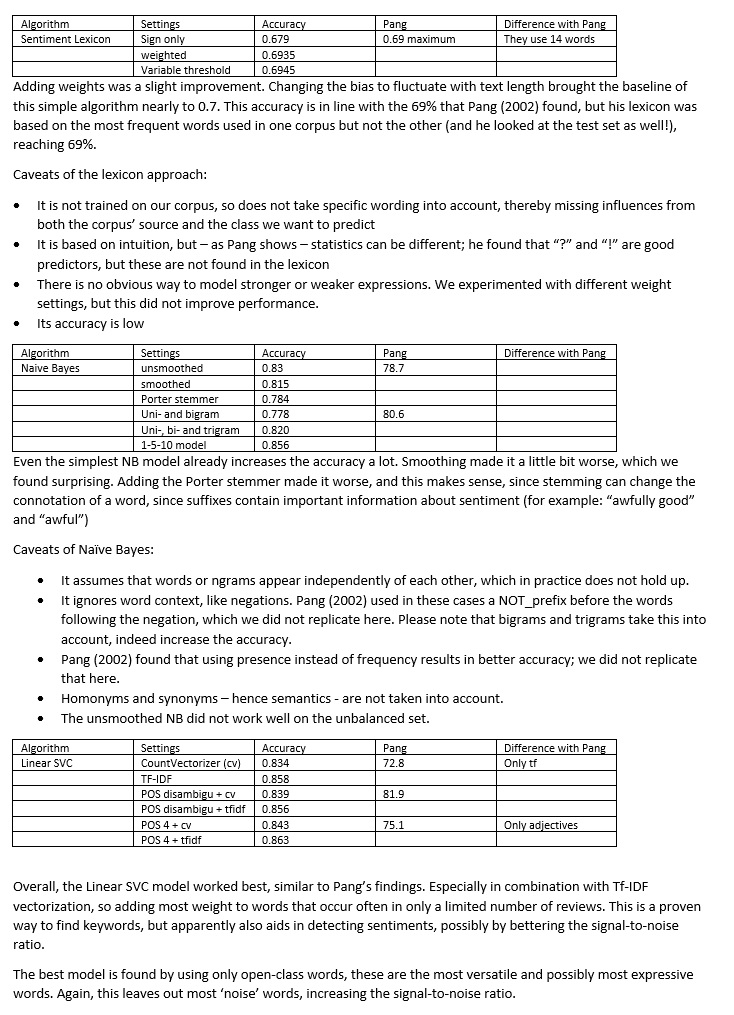

# Submission 


In [ ]:
# Write your names and student numbers here:
# Linda Hovius 12205184
# Elynn Weijland 13895958

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 